In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as time
import os

In [2]:
day = pd.Timestamp('today') #formatted as date number
today = time.date.today() #formatted as y-m-d
VB = [44099]
reports = ['spec', 'txt']

outputs = []
for buoy in VB:
    concat1 = str(buoy) + '_' + 'spec'
    concat2 = str(buoy) + '_' + 'txt'
    outputs.append(concat1)
    outputs.append(concat2)

In [3]:
def import_noaa_waves(buoy):
#give buoy number, requests runs it, convert to txt, split txt, regroup into df and then ???
#import txt file from noaa website
    noaa_object = requests.get(f'https://www.ndbc.noaa.gov/data/realtime2/{buoy}.spec')
    noaa_txt = noaa_object.text
#test that import actually worked
    try:
        noaa_object.raise_for_status()
    except Exception as exc:
        print('Request didn\'t work!')
#convert object into text form and split into workable pieces
    noaa_split = []
    for ele in noaa_txt.split():
        noaa_split.append(ele)
    records = []
#create 15 character blocks that will be made into rows
    for i in range(0, len(noaa_split), 15):
        records.append(noaa_split[i:i + 15])
#create dataframe from list of record chunks and drop two header rows
    df = pd.DataFrame(records, columns=records[0])
    df = df.drop([0,1])
    df['Date'] = df['MM'].astype(str) + '-' + df['DD'].astype(str) + '-' + df['#YY'].astype(str)
    df['Time'] = df['hh'].astype(str) + ':' + df['mm'].astype(str)
    df['Timestamp'] = df['Date'] + ' ' + df['Time']
#use loc to keep last 3 days of swell data
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Timestamp',ascending=False)
    df = df.loc[df.Date >= day - time.timedelta(days = 2)]
    df = df[['Timestamp','WVHT', 'SwH','WWH','WWP','SwD','WWD','APD','MWD']]
#map swell dir to cardinal dir
    df['MWD'] = pd.to_numeric(df['MWD'])
    df['APD'] = pd.to_numeric(df['APD'])
    def map_degrees(data):
        if data.MWD <= 22:
            return 'N'
        elif data.MWD <= 67:
            return 'NE'
        elif data.MWD <= 112:
            return 'E'
        elif data.MWD <= 157:
            return 'SE'
        elif data.MWD <= 202:
            return 'S'
        elif data.MWD <= 247:
            return 'SW'
        elif data.MWD <= 292:
            return 'W'
        elif data.MWD <= 337:
            return 'NW'
        else: 
            return 'N'
    df['MWD_DIR'] = df.apply(map_degrees, axis=1)
#convert meters to feet
    df['WVHT'] = df['WVHT'].apply(lambda i: round(float(i) * 3.28084,2))
    df['SwH'] = df['SwH'].apply(lambda i: round(float(i) * 3.28084,2))
    df['WWH'] = df['WWH'].apply(lambda i: round(float(i) * 3.28084,2))
#normalize compass degrees to circle degrees
    def normalize_degrees(data):
        if data.MWD >= 90:
            adj = data.MWD - 90
            return 360 - adj
        else: 
            adj = abs(data.MWD - 90)
            return adj
    df['MWD_Norm'] = df.apply(normalize_degrees, axis=1)
#chart swell trend
    x = df.Timestamp
    y1 = df.WVHT
    y2 = df.APD
    x_dates = []
    u = []
    v = []
    avg = df.WVHT.mean()
    min = df.WVHT.min()
#create x labels for every 4th record
    for i, date in enumerate(df.Timestamp):
        if i % 4 == 0:
            x_dates.append(date)
        else:
            pass
#loc xdate values in df and calc u/v w text labels
    xdate_df = df.loc[df['Timestamp'].isin(x_dates)]
    for record in xdate_df.MWD_Norm:
        u.append(np.cos(record*(np.pi/180)))
        v.append(np.sin(record*(np.pi/180)))
#swell chart
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 13), gridspec_kw={'height_ratios':[2,1]})
    plt.subplots_adjust(top=1.5)
    ax1.stem(x, y1, bottom = avg)
    ax1.plot(x,y1,marker='o')
    ax1.quiver(x_dates, min-0.03, u, v, pivot='middle',scale=22)
    ax1.set_ylabel('Swell in Feet') 
#period chart
    ax2.stem(x, y2)
    ax2.plot(x,y2,marker='o')
    ax2.set_xticks(x_dates)
    ax2.xaxis.tick_top()
    ax2.set_xticklabels(x_dates, rotation = 45, fontsize = 13)
    ax2.xaxis.set_label_position('top') 
    ax2.set_ylabel('Swell Period in Seconds')
    plt.subplots_adjust(left=0.065,bottom=0.046,right=0.98,top=0.956,hspace=0.333)
    #plt.show()
    os.chdir(r"C:\Users\cates\Buoy Reports")
    plt.savefig(fname=f'{today}-waves.png')

In [4]:
def message_txt(buoy):
    noaa_object = requests.get(f'https://www.ndbc.noaa.gov/data/realtime2/{buoy}.spec')
    noaa_txt = noaa_object.text
#test that import actually worked
    try:
        noaa_object.raise_for_status()
    except Exception as exc:
        print('Request didn\'t work!')
#convert object into text form and split into workable pieces
    noaa_split = []
    for ele in noaa_txt.split():
        noaa_split.append(ele)
    records = []
#create 15 character blocks that will be made into rows
    for i in range(0, len(noaa_split), 15):
        records.append(noaa_split[i:i + 15])
#create dataframe from list of record chunks and drop two header rows
    df = pd.DataFrame(records, columns=records[0])
    df = df.drop([0,1])
    df['Date'] = df['MM'].astype(str) + '-' + df['DD'].astype(str) + '-' + df['#YY'].astype(str)
    df['Time'] = df['hh'].astype(str) + ':' + df['mm'].astype(str)
    df['Timestamp'] = df['Date'] + ' ' + df['Time']
#use loc to keep last 3 days of swell data
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Timestamp',ascending=False)
    df = df.loc[df.Date >= day - time.timedelta(days = 2)]
    df = df[['Timestamp','WVHT', 'SwH','WWH','WWP','SwD','WWD','APD','MWD']]
#map swell dir to cardinal dir
    df['MWD'] = pd.to_numeric(df['MWD'])
    df['APD'] = pd.to_numeric(df['APD'])
    def map_degrees(data):
        if data.MWD <= 22:
            return 'N'
        elif data.MWD <= 67:
            return 'NE'
        elif data.MWD <= 112:
            return 'E'
        elif data.MWD <= 157:
            return 'SE'
        elif data.MWD <= 202:
            return 'S'
        elif data.MWD <= 247:
            return 'SW'
        elif data.MWD <= 292:
            return 'W'
        elif data.MWD <= 337:
            return 'NW'
        else: 
            return 'N'
    df['MWD_DIR'] = df.apply(map_degrees, axis=1)
#convert meters to feet
    df['WVHT'] = df['WVHT'].apply(lambda i: round(float(i) * 3.28084,2))
    df['SwH'] = df['SwH'].apply(lambda i: round(float(i) * 3.28084,2))
    df['WWH'] = df['WWH'].apply(lambda i: round(float(i) * 3.28084,2))
    return df

def import_noaa_met(buoy):
#import txt file from noaa website
    noaa_object = requests.get(f'https://www.ndbc.noaa.gov/data/realtime2/{buoy}.txt')
    noaa_txt = noaa_object.text
#test that import actually worked
    try:
        noaa_object.raise_for_status()
    except Exception as exc:
        print('Request didn\'t work!')
#convert object into text form and split into workable pieces
    noaa_split = []
    for ele in noaa_txt.split():
        noaa_split.append(ele)
    records = []
#create 19 character blocks that will be made into rows
    for i in range(0, len(noaa_split), 19):
        records.append(noaa_split[i:i + 19])
#create list of watertemp records with dates and convert to farenheit
    df = pd.DataFrame(records, columns=records[0])
    df = df.drop([0,1])
    df = df.drop(columns = ['WDIR','WSPD','GST','WVHT','DPD','APD','MWD','PRES','ATMP','DEWP','VIS','PTDY','TIDE'])
    df['deg_f'] = df['WTMP'].apply(lambda i: float(i) * (9/5) + 32)
    df['Date'] = df['MM'].astype(str) + '-' + df['DD'].astype(str) + '-' + df['#YY'].astype(str)
    df = df.drop(columns=['WTMP','mm','#YY','MM','DD'])
    df.drop_duplicates()
#group data by day
    df = df.groupby('Date').mean('deg_f')
#chart temp trend
    x = df.index 
    y = df.deg_f
    plt.figure(figsize=(15,5))
    plt.plot(x, y, marker ='o')
    plt.ylabel('Temp F') 
    plt.xticks(rotation=90)
    for x, y in zip(x,y):
        plt.text(x, y, s=round(y))
    plt.subplots_adjust(left=0.06, bottom=0.232, right=0.968, top=0.968)
    #plt.show()
    plt.savefig(fname=f'{today}-water.png')


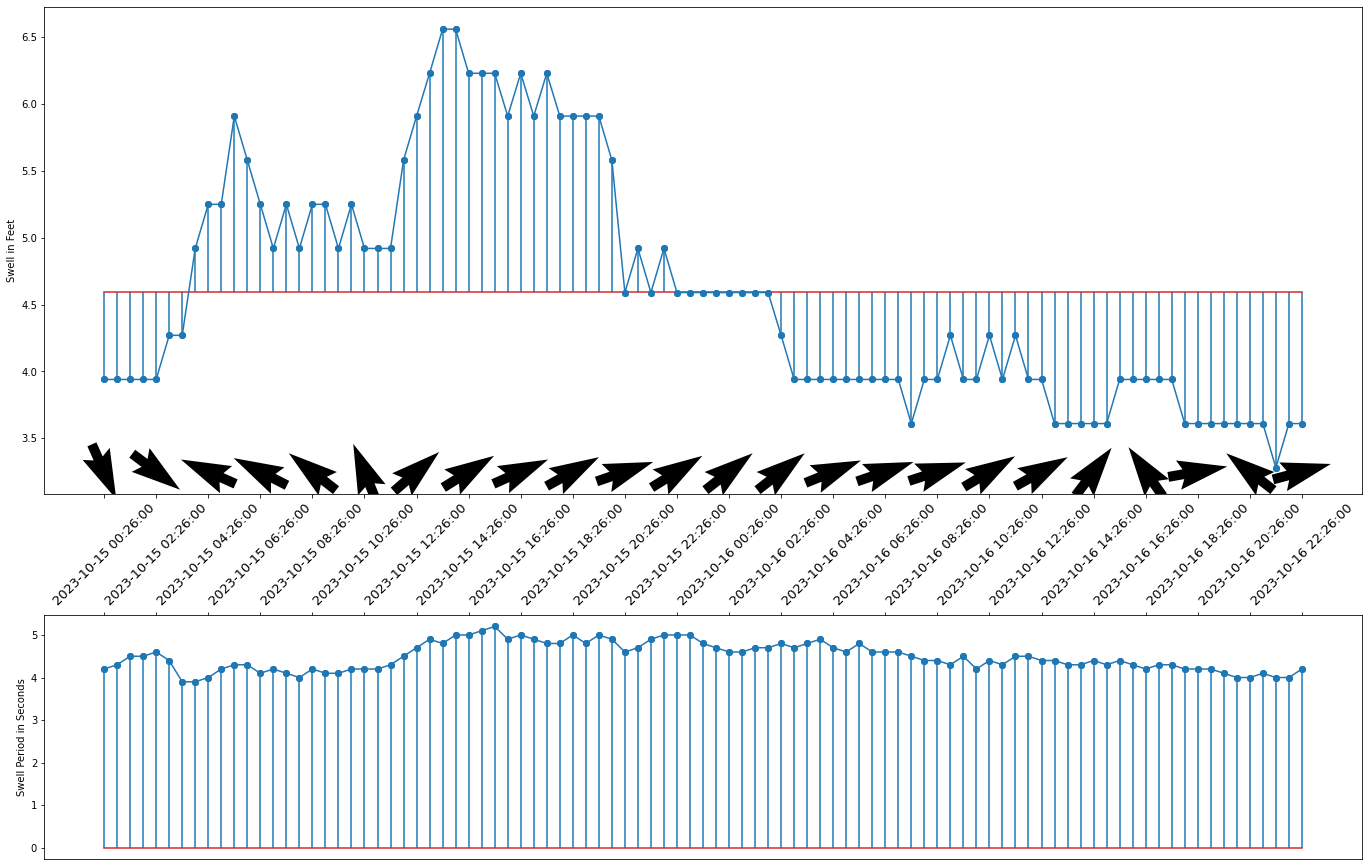

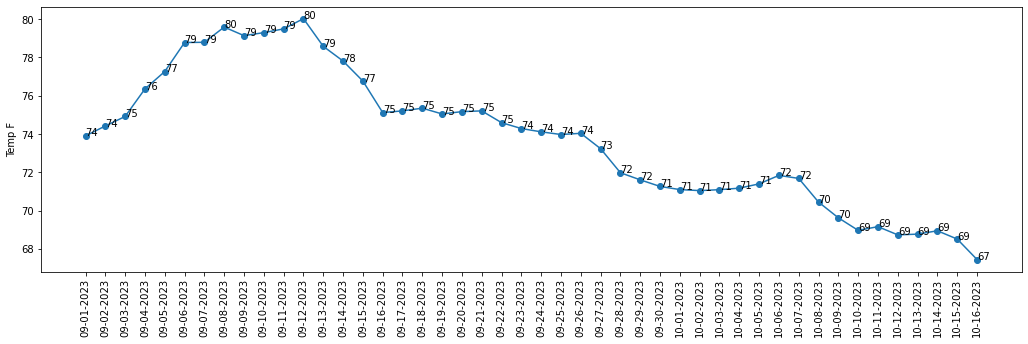

In [5]:
import_noaa_waves(VB[0])
import_noaa_met(VB[0])